In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
MAC = '20:20:00:00:00:06'
LOG_DIR = "../log/loss/"
DATA_DIR = "../dataset/train/"
TRAINING_LOG_FILE = LOG_DIR + MAC.replace(':','-') + '.csv'
DATA_FILE = DATA_DIR + MAC.replace(':','-') + '.csv'

In [3]:
log_df = pd.read_csv(TRAINING_LOG_FILE)
# convert to meter scale
log_df.x *= 0.01
log_df.y *= 0.01

df = pd.read_csv(DATA_FILE)
df['x'] = df['UE_X'] * 0.01
df['y'] = df['UE_Y'] * 0.01

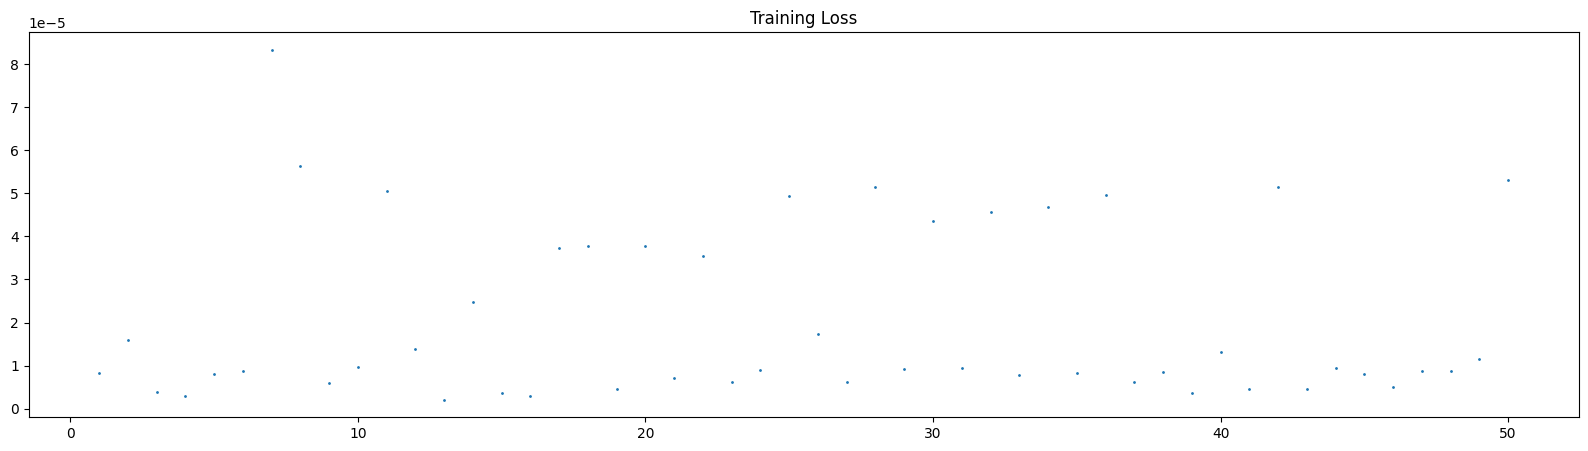

In [4]:
plt.figure(figsize=(20,5))
plt.scatter(log_df.iteration, log_df.loss, s=1)
plt.title('Training Loss')
plt.show()

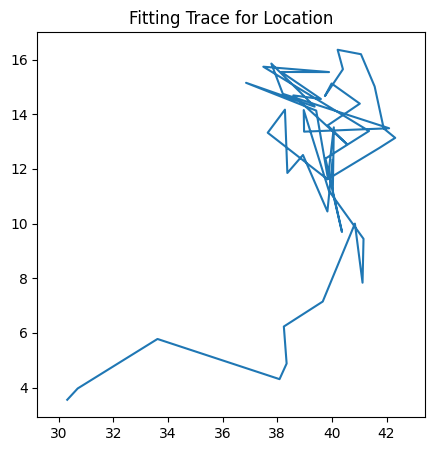

In [5]:
plt.figure(figsize=(5,5))
plt.plot(log_df.x, log_df.y)
plt.title('Fitting Trace for Location')
plt.axis('equal')
plt.show()

## Normalize

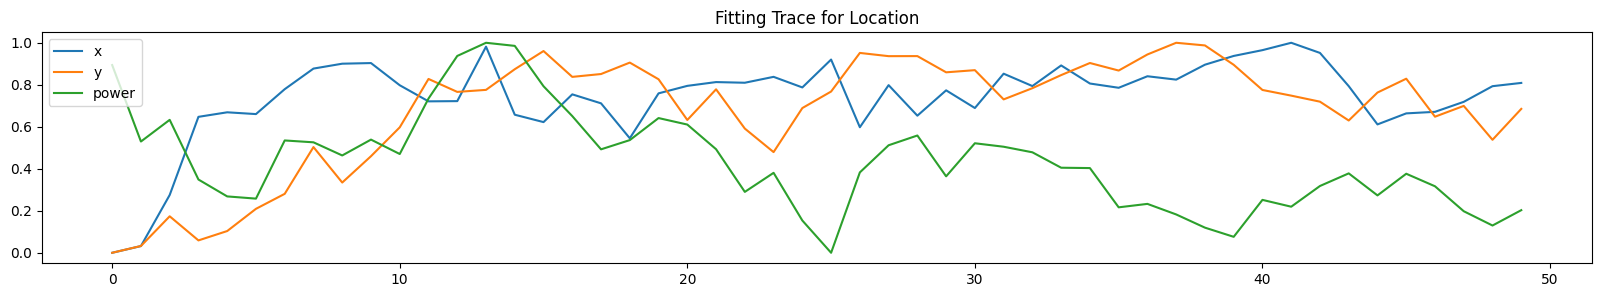

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = log_df.columns[1:-1]
df_norm = pd.DataFrame(scaler.fit_transform(log_df[columns]), columns=columns)

plt.figure(figsize=(20,3))
plt.plot(df_norm.x, label='x')
plt.plot(df_norm.y, label='y')
plt.plot(df_norm.power,label='power')
plt.title('Fitting Trace for Location')
plt.legend()
plt.show()

In [7]:
from scipy.optimize import least_squares
import signals

def get_ls_estimation(df, rss_window=100):
    data = df[df.RSS > df.RSS.max() - rss_window][['x','y','RSS']].to_numpy()
        
    def cost(state, observation):
        x0, y0, pt_mW = state
        x1, y1, rss_dBm = observation
        d = signals.calc_distance_with(pt_mW=pt_mW, rss_dBm=rss_dBm)
        return np.power(np.sqrt((x0-x1)**2 + (y0-y1)**2) - d, 2)

    def fit(x):
        c = 0
        for observation in data:
            c += cost(x, observation)
        return c

    init_state = (data[:,0].mean(), data[:,1].mean() , 0.01)
    res = least_squares(fit, init_state)
    return  {'x':res.x[0], 'y':res.x[1], 'power': res.x[2]}
ls_est = get_ls_estimation(df)

C:\Users\zhong\Documents\GitHub\WirelessDT\Source\WiTracingSGD\analysis\signals.py:13: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(pt_mW / (dBmTomW(rss_dBm) * 4 * np.pi))


In [8]:
def get_best_wt_estimation(df):
    min_index = df['loss'].idxmin()
    row = df.loc[min_index]
    return {'x': row['x'], 'y':row['y'], 'power': row['power']}
wt_est = get_best_wt_estimation(log_df)

def calc_wt_distance(row):
    return np.sqrt(np.power(wt_est['x']-row.x,2) + np.power(wt_est['y'] - row.y, 2))

def calc_ls_distance(row):
    return np.sqrt(np.power(ls_est['x']-row.x,2) + np.power(ls_est['y'] - row.y, 2))

df['WT Distance'] = df.apply(calc_wt_distance, axis=1)
df['LS Distance'] = df.apply(calc_ls_distance, axis=1)

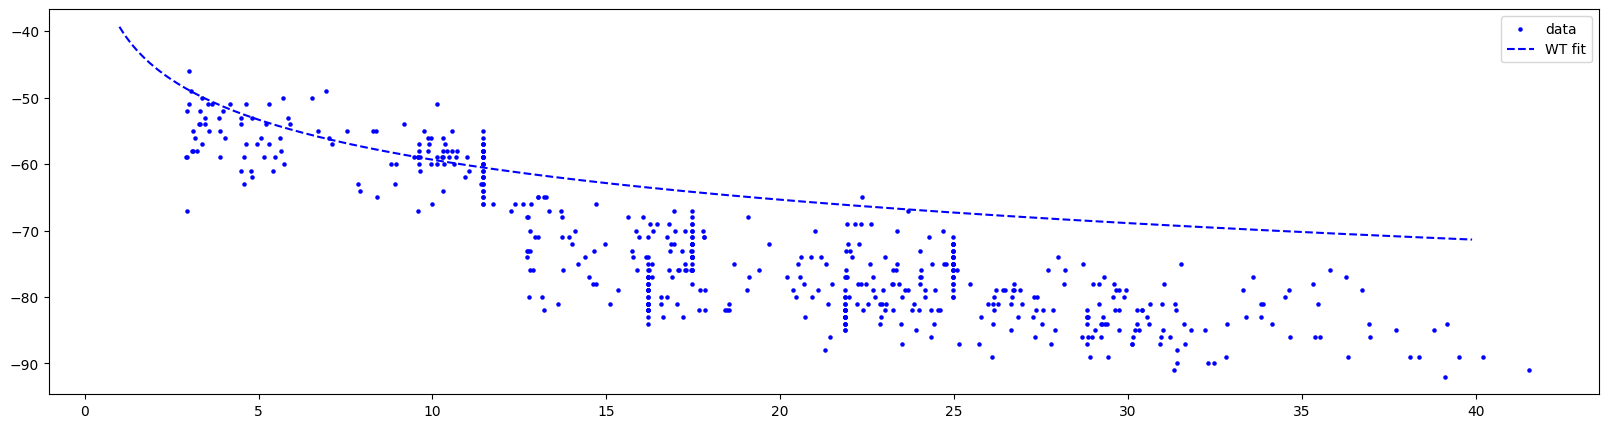

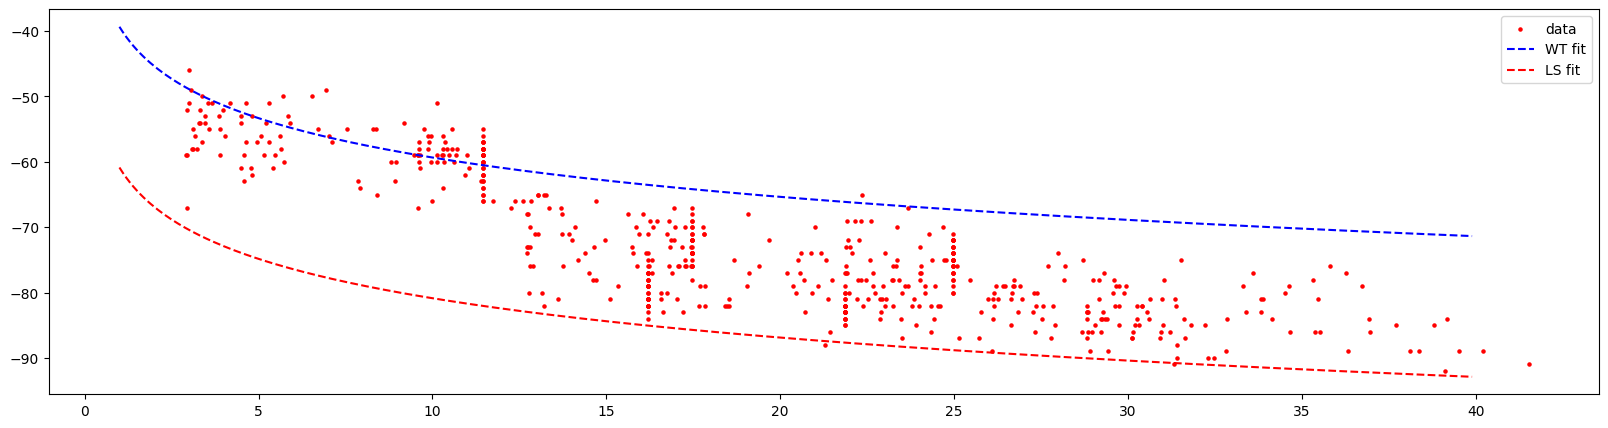

In [9]:
SYSTEM_GAIN = -45

distances = np.arange(1,40,0.1)
wt_rss = signals.mWTodBm(signals.calc_rss_at(pt_mW=wt_est['power'], d=distances)) + SYSTEM_GAIN
ls_rss = signals.mWTodBm(signals.calc_rss_at(pt_mW=ls_est['power'], d=distances))

plt.figure(figsize=(20,5))
plt.scatter(df['WT Distance'], df['RSS'], s=5, color="b",label='data')
plt.plot(distances, wt_rss, color='b', linestyle='--',label='WT fit')
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.scatter(df['WT Distance'], df['RSS'], s=5, color="r",label='data')
plt.plot(distances, wt_rss, color='b', linestyle='--',label='WT fit')
plt.plot(distances, ls_rss, color='r', linestyle='--',label='LS fit')
plt.legend()
plt.show()